In [99]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
import sys, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, Conv1DTranspose, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [121]:
base_data_train, base_data_test = np.load('../data/tuning/sampled_based_data1yr_spaced.npy', allow_pickle=True)
vae_data_train = np.load('../data/th_v_air_samples.npy')
vae_data_train_scaled = np.load('../data/th_v_air_scaled_samples.npy')
base_data_train, base_data_test, vae_data_train = base_data_train[:,:,[0,3]], base_data_test[:,:,[0,3]], vae_data_train[:,:,[0,1]]
print(base_data_train.shape,vae_data_train.shape)

(108, 730, 2) (5000, 730, 2)


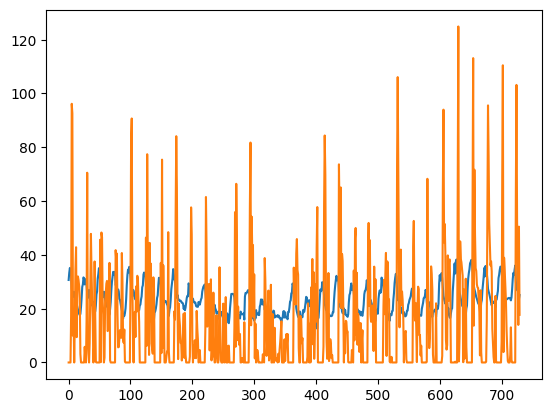

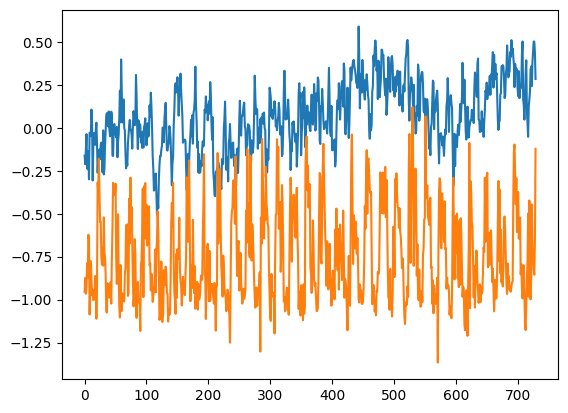

In [122]:
plt.plot(base_data_train[100])
plt.show()
plt.plot(vae_data_train[200])
plt.show()

In [123]:
'''def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear') #Dense(1)
    ])
    return model

def create_cnn(input_length):
    model = Sequential([
        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),
        Dropout(0.5),
        LSTM(32, return_sequences=True),
        GlobalAveragePooling1D(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear')  # Output layer for regression
    ])
    return model'''

"def create_cnn(input_shape):\n    model = Sequential([\n        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),\n        MaxPooling1D(pool_size=2),\n        Flatten(),\n        Dense(50, activation='relu'),\n        Dense(730, activation='linear') #Dense(1)\n    ])\n    return model\n\ndef create_cnn(input_length):\n    model = Sequential([\n        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),\n        Dropout(0.5),\n        LSTM(32, return_sequences=True),\n        GlobalAveragePooling1D(),\n        Dense(50, activation='relu'),\n        Dense(730, activation='linear')  # Output layer for regression\n    ])\n    return model"

In [124]:
def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=24, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Conv1D(filters=64, kernel_size=24, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(730, activation='linear')
    ])
    return model

In [125]:
print(base_data_train[:,:,0].shape)

(108, 730)


In [137]:
def test_cnn(training_data):
    X_train = training_data[:,:,0].reshape(-1,730,1)
    y_train = training_data[:,:,1]

    X_test = scaled_data_test[:,:,0].reshape(-1, 730, 1)  
    y_test = scaled_data_test[:,:,1]

    X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
                                                                  
    model = create_cnn((X_train.shape[1], X_train.shape[2]))
    model.compile(optimizer=Adam(), loss='mse', metrics=['mse', 'mae', 'accuracy'])

    early_stopping = EarlyStopping(monitor='mse', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.5, patience=5, verbose=1)
    model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[early_stopping, reduce_lr], verbose=1, validation_data=(X_train_val, y_train_val))

    loss, mse, mae, accuracy = model.evaluate(X_test, y_test)
    r2 = r_squared(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(model.predict(X_test), dtype=tf.float32))
    
    return {'mse':mse, 'mae':mae, 'r2':r2.numpy(), 'acc':accuracy}


<h3> Scaling data before evaluation </h3>

Scale base dataset and use the scaled vae dataset

In [138]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]

temp_var, temp_var_test = scalers['G.air.T'].fit_transform(temp_var), scalers['G.air.T'].fit_transform(temp_var_test)
energy_var, energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var), scalers['G.E_th_I'].fit_transform(energy_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 2) (12, 730, 2)


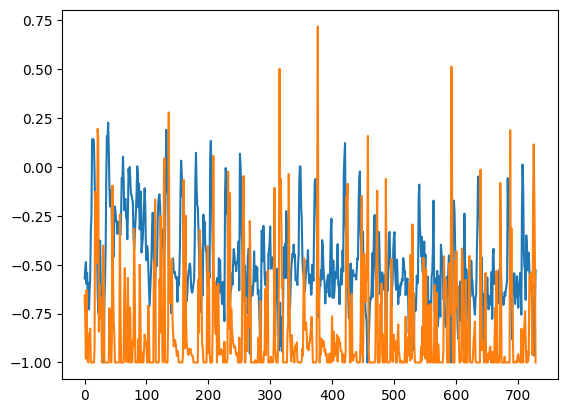

In [139]:
plt.plot(scaled_data_train[10])

Clip energy consumption at 0 and rescale

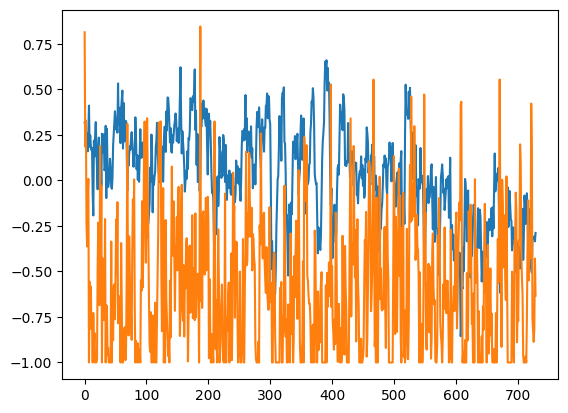

In [140]:
clipped_vae_train = np.clip(vae_data_train_scaled, a_min=0, a_max=None)
clipped_temp, clipped_energy = clipped_vae_train[:,:,0], clipped_vae_train[:,:,1]
clipped_temp, clipped_energy = scalers['G.air.T'].fit_transform(clipped_temp), scalers['G.E_th_I'].fit_transform(clipped_energy) 

clipped_vae_train = np.stack((clipped_temp, clipped_energy), axis=-1)
plt.plot(clipped_vae_train[50])

<h3> Use CNN to assess ground truth data </h3>

In [141]:
gt_test = test_cnn(scaled_data_train)
print(gt_test['mse'], gt_test['mae'], gt_test['r2'], gt_test['acc'])

Epoch 1/100
6/6 [==============================] - 1s 62ms/step - loss: 0.6506 - mse: 0.6506 - mae: 0.7383 - accuracy: 0.0000e+00 - val_loss: 0.5582 - val_mse: 0.5582 - val_mae: 0.6783 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 33ms/step - loss: 0.4705 - mse: 0.4705 - mae: 0.5786 - accuracy: 0.0000e+00 - val_loss: 0.3693 - val_mse: 0.3693 - val_mae: 0.5197 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 28ms/step - loss: 0.3118 - mse: 0.3118 - mae: 0.4436 - accuracy: 0.0000e+00 - val_loss: 0.2462 - val_mse: 0.2462 - val_mae: 0.4057 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 30ms/step - loss: 0.2252 - mse: 0.2252 - mae: 0.3574 - accuracy: 0.0000e+00 - val_loss: 0.2021 - val_mse: 0.2021 - val_mae: 0.3657 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 29ms/step - loss: 0.1920 - mse: 0.1920 - mae: 

<h3> Use CNN to assess synthetic data</h3>

Clipped VAE data

In [148]:
clipped_synth_test = test_cnn(clipped_vae_train[0:216,:,:])
print(clipped_synth_test['mse'], clipped_synth_test['mae'], clipped_synth_test['r2'], clipped_synth_test['acc'])

Epoch 1/100
11/11 [==============================] - 1s 45ms/step - loss: 0.3972 - mse: 0.3972 - mae: 0.5416 - accuracy: 0.0000e+00 - val_loss: 0.2596 - val_mse: 0.2596 - val_mae: 0.4281 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 26ms/step - loss: 0.1690 - mse: 0.1690 - mae: 0.3207 - accuracy: 0.0000e+00 - val_loss: 0.1123 - val_mse: 0.1123 - val_mae: 0.2623 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0919 - mse: 0.0919 - mae: 0.2359 - accuracy: 0.0000e+00 - val_loss: 0.0869 - val_mse: 0.0869 - val_mae: 0.2323 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0786 - mse: 0.0786 - mae: 0.2189 - accuracy: 0.0116 - val_loss: 0.1031 - val_mse: 0.1031 - val_mae: 0.2726 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0746 - mse: 0.0746 - mae: 0.

Unclipped data

In [149]:
synth_test = test_cnn(vae_data_train[0:216,:,:])
print(synth_test['mse'], synth_test['mae'], synth_test['r2'], synth_test['acc'])

Epoch 1/100
11/11 [==============================] - 1s 44ms/step - loss: 0.5048 - mse: 0.5048 - mae: 0.6239 - accuracy: 0.0000e+00 - val_loss: 0.2735 - val_mse: 0.2735 - val_mae: 0.4147 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 25ms/step - loss: 0.1595 - mse: 0.1595 - mae: 0.2986 - accuracy: 0.0000e+00 - val_loss: 0.0792 - val_mse: 0.0792 - val_mae: 0.2135 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 29ms/step - loss: 0.0530 - mse: 0.0530 - mae: 0.1746 - accuracy: 0.0000e+00 - val_loss: 0.0494 - val_mse: 0.0494 - val_mae: 0.1738 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.1457 - accuracy: 0.0116 - val_loss: 0.0402 - val_mse: 0.0402 - val_mae: 0.1546 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0326 - mse: 0.0326 -

<h3> Use CNN to evaluate synthetic-ground truth blended data</h3>

Clipped VAE data

In [150]:
clipped_blended_data = np.concatenate((scaled_data_train, clipped_vae_train[0:216,:,:]), axis=0)
clipped_blended_test = test_cnn(clipped_blended_data)
print(clipped_blended_test['mse'], clipped_blended_test['mae'], clipped_blended_test['r2'], clipped_blended_test['acc'])

Epoch 1/100
17/17 [==============================] - 1s 37ms/step - loss: 0.3858 - mse: 0.3858 - mae: 0.5189 - accuracy: 0.0077 - val_loss: 0.2068 - val_mse: 0.2068 - val_mae: 0.3706 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 0s 24ms/step - loss: 0.1518 - mse: 0.1518 - mae: 0.2961 - accuracy: 0.0039 - val_loss: 0.1338 - val_mse: 0.1338 - val_mae: 0.2982 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 0s 24ms/step - loss: 0.1163 - mse: 0.1163 - mae: 0.2528 - accuracy: 0.0039 - val_loss: 0.1148 - val_mse: 0.1148 - val_mae: 0.2679 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 0s 24ms/step - loss: 0.1101 - mse: 0.1101 - mae: 0.2453 - accuracy: 0.0077 - val_loss: 0.1119 - val_mse: 0.1119 - val_mae: 0.2641 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 0s 25ms/step - loss: 0.1092 - mse: 0.1092 - mae: 0.2441

In [145]:
print(clipped_blended_test['mse'], clipped_blended_test['mae'], clipped_blended_test['r2'], clipped_blended_test['acc'])

0.3179050385951996 0.3967043459415436 0.22839642 0.0


Unclipped data

In [151]:
blended_data = np.concatenate((scaled_data_train, clipped_vae_train[0:216,:,:]), axis=0)
blended_test = test_cnn(blended_data)
print(blended_test['mse'], blended_test['mae'], blended_test['r2'], blended_test['acc'])

Epoch 1/100
17/17 [==============================] - 1s 33ms/step - loss: 0.3716 - mse: 0.3716 - mae: 0.5080 - accuracy: 0.0000e+00 - val_loss: 0.2088 - val_mse: 0.2088 - val_mae: 0.3642 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 0s 23ms/step - loss: 0.1437 - mse: 0.1437 - mae: 0.2817 - accuracy: 0.0039 - val_loss: 0.1455 - val_mse: 0.1455 - val_mae: 0.3109 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 0s 23ms/step - loss: 0.1103 - mse: 0.1103 - mae: 0.2461 - accuracy: 0.0039 - val_loss: 0.1370 - val_mse: 0.1370 - val_mae: 0.3007 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 0s 23ms/step - loss: 0.1086 - mse: 0.1086 - mae: 0.2452 - accuracy: 0.0039 - val_loss: 0.1238 - val_mse: 0.1238 - val_mae: 0.2703 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 0s 23ms/step - loss: 0.1062 - mse: 0.1062 - mae: 0.